In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Функция печати изображения в монохромном формате

def imshow(img, cmap = "gray"):
    plt.imshow(img, cmap)
    plt.show()

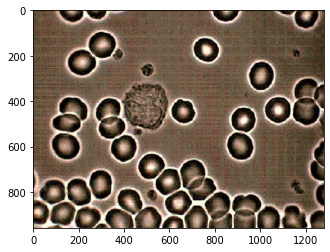

In [3]:
img = cv2.imread("cells.jpg")
plt.imshow(img)

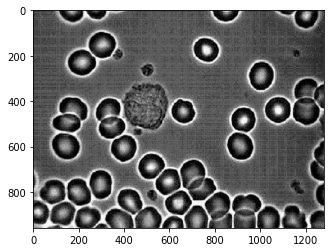

In [4]:
# Перевод изображения в монохромное

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

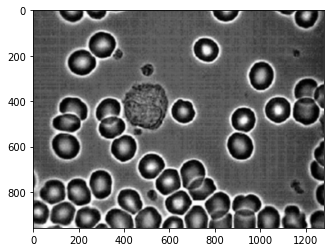

In [5]:
# На изображении присутствует шум: необходимо применить фильтр Blur

size = 7
blur_kernel = np.ones((size,size))
blur_kernel /= (size*size)
gray = cv2.filter2D(gray, -1, blur_kernel)
imshow(gray)

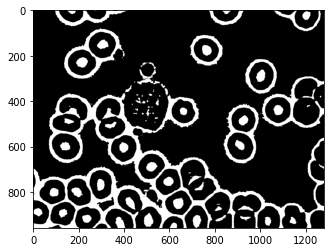

In [6]:
# Попытка применить MORPH_GRADIENT

thresh, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
imshow(binary)

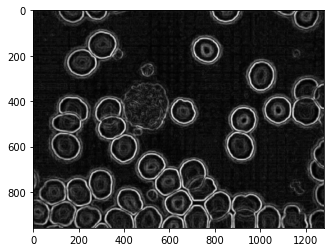

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)
imshow(gradient)

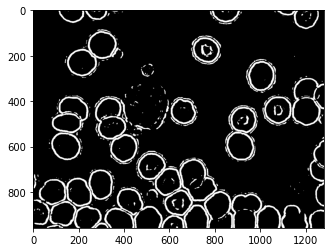

In [8]:
# Как видно из изображения, помимо границ клеток, добавились и их сердцевины

thresh, binary = cv2.threshold(gradient, 0, 255, cv2.THRESH_OTSU)
imshow(binary)

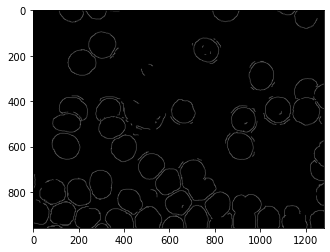

In [10]:
# Необходимо получить границы клеток. Для этого воспользуемся детектором Canny

canny = cv2.Canny(gray, 120, 200)
imshow(canny)

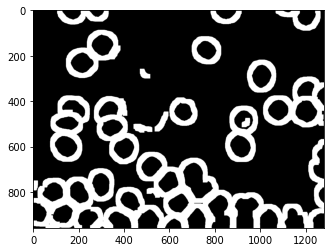

In [71]:
# Теперь необходимо нарастить компонетны по их границам.

# Для определения мест соприкосновения клеток друг с другом
first_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
first_morph = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, first_kernel, iterations = 2)
second_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
second_morph = cv2.morphologyEx(first_morph, cv2.MORPH_DILATE, second_kernel, iterations = 2)
third_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 12))
third_morph = cv2.morphologyEx(second_morph, cv2.MORPH_DILATE, third_kernel, iterations = 1)

imshow(third_morph)

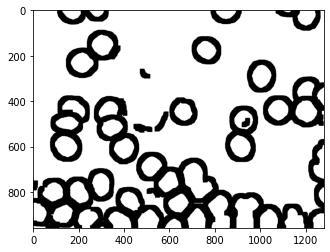

In [72]:
# Инвертируем изображение для получения компонент. Стоит заметить, что есть объекты, которые не являются клетками, но будут считаться компонентами.
# Их необходимо убрать. Для начала получим все компоненты

invers = 255 - third_morph

count, markers = cv2.connectedComponents(invers)
imshow(invers)

In [73]:
count

53

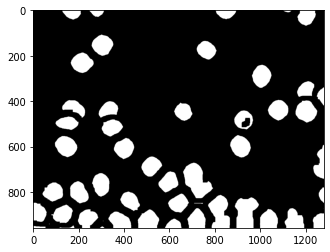

In [74]:
# Стоит отметить, что 0 и 1 компоненты - это фон и оболочки, полученные наращиванием границ. Нам нужны только клетки, поэтому оставим только их
# Чтобы убрать лишние компоненты, необходимо снова перейти к чёрно-белому изображению

bw = np.zeros(invers.shape, dtype = 'uint8')
for n in np.unique(markers):
    if n > 1:
        bw[markers == n] = 255
        
imshow(bw)

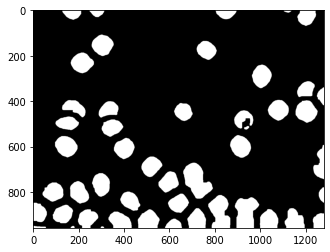

In [75]:
# Для начала, уберём лишние мелкие компоненты, затем нарастим обратно те, которые ищем

first_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
first_morph = cv2.morphologyEx(bw, cv2.MORPH_ERODE, first_kernel, iterations=1)

# Наращиваем обратно те компоненты, которые нужны
second_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
second_morph = cv2.morphologyEx(first_morph, cv2.MORPH_DILATE, second_kernel, iterations=1)

imshow(second_morph)

In [76]:
# Cчитаем контуры, нужны только внешние
import imutils

contours = cv2.findContours(second_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('Всего найдено клеток', len(imutils.grab_contours(contours)))

Всего найдено клеток 48


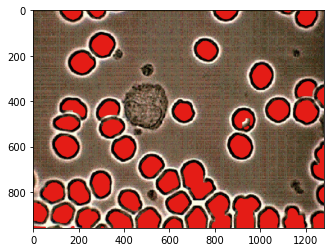

In [77]:
# Отображение на исходном изображении найденных клеток
copy = img.copy()
copy[second_morph == 255] = [228, 28, 22]
imshow(copy)